In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.downloader.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
# nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/msinxi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [3]:
# have a look at some text
raw_data['Text'].head()

0    I bought a car through a dealership and had so...
1    April 7, 2006 Wells Fargo Bank announced they ...
2    Securities watchdog investigates Wells Fargo o...
3    I had a problem where for months my student lo...
4    If someone opens a bank account without your k...
Name: Text, dtype: object

In [4]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    lemma = WordNetLemmatizer()
    porter = PorterStemmer()
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    normalized = " ".join(lemma.lemmatize(word) for word in s.split())
    stemmed = " ".join(porter.stem(word) for word in normalized.split())
    return stemmed

In [5]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
raw_data['Text'] = raw_data['Text'].apply(clean_text)

## Frequent terms

In [7]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=None, stop_words = 'english' )
vectorizer.fit(raw_data['Text'])
vect_sentences  = vectorizer.transform(raw_data['Text'])
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [8]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

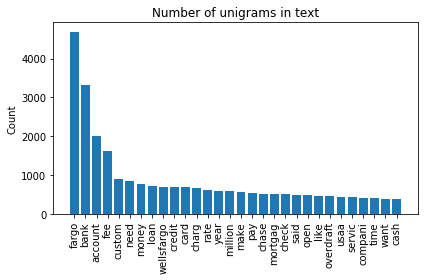

In [9]:
plt.bar(label[::-1],value[::-1])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of unigrams in text')
plt.tight_layout()
plt.savefig('./Reports/figures/unigram_freq.png')
# plt.ylim([150,])

In [161]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=None, stop_words = 'english' )
vectorizer.fit(raw_data['Text'])
vect_sentences  = vectorizer.transform(raw_data['Text'])
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [162]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

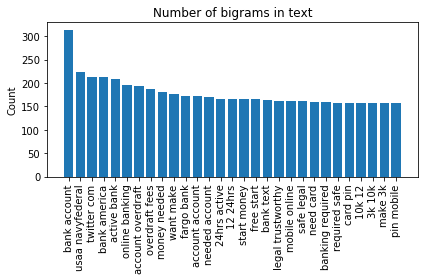

In [163]:
plt.bar(label[::-1][1:],value[::-1][1:])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of bigrams in text')
plt.tight_layout()
plt.savefig('./Reports/figures/bigram_freq.png')
# plt.ylim([150,])

In [24]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=None, stop_words = 'english' )
vectorizer.fit(raw_data['Text'])
vect_sentences  = vectorizer.transform(raw_data['Text'])
sum_words = vect_sentences.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words = sorted(words_freq, key=lambda x: x[1])

In [25]:
label = [l[0] for l in words[-30:]]
value = [v[1] for v in words[-30:]]

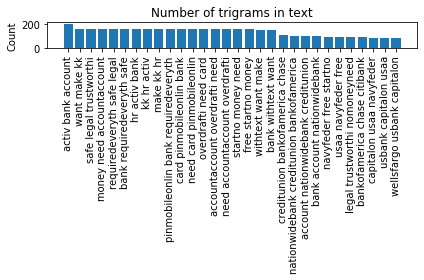

In [62]:
plt.bar(label[::-1],value[::-1])
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of trigrams in text')
plt.tight_layout()
plt.savefig('./Reports/figures/trigram_freq.png')
# plt.ylim([150,])

## Sentiment analysis

In [28]:
sia = SentimentIntensityAnalyzer()

In [25]:
collected_sentiment = raw_data['Text'].apply(lambda x: sia.polarity_scores(x))

In [26]:
raw_data['sentiment'] = collected_sentiment.apply(lambda x: x['compound'])

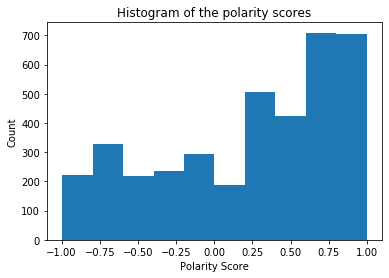

In [173]:
plt.hist(collected_sentiment.apply(lambda x: x['compound']))
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.title('Histogram of the polarity scores')
plt.savefig('Reports/figures/sentiment_v1.png')

In [130]:
print([p for p in nltk.pos_tag(raw_data['Text'].iloc[idx].split()) if p[1] in ['JJ', 'JJR', 'JJS', 'VBD', 'VBN', 'NN']]) # if p[1] in ['JJ', 'JJR', 'JJS', 'VBD', 'VBN']
cleaned = ' '.join(
    [p[0] for p in nltk.pos_tag(raw_data['Text'].iloc[idx].split())
     if p[1] in ['JJ', 'JJR', 'JJS', 'VBD', 'VBN']])
print(cleaned)
sia.polarity_scores(cleaned)

[('/u/0-43027', 'NN'), ('fargo', 'NN'), ('overdraft', 'NN'), ('question', 'NN'), ('stupid.', 'JJ'), ('ruthless', 'JJ'), ('best,', 'NN'), ('amoral.', 'NN')]
stupid. ruthless


{'neg': 0.773, 'neu': 0.227, 'pos': 0.0, 'compound': -0.5267}

In [131]:
cleaned_text = raw_data['Text'].apply(lambda x: 
                       " ".join([p[0] for p in nltk.pos_tag(x.split()) 
                                 if p[1] in ['JJ', 'JJR', 'JJS', 'VBD', 'VBN', 'NN']] ))

In [132]:
raw_data['cleaned_sentiment'] = cleaned_text.apply(lambda x: sia.polarity_scores(x))

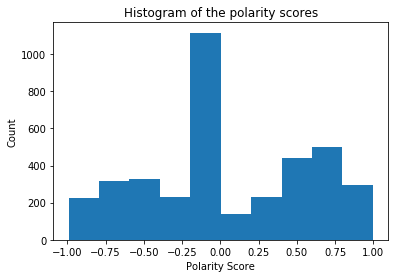

In [174]:
plt.hist(raw_data['cleaned_sentiment'].apply(lambda x: x['compound']))
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.title('Histogram of the polarity scores')
plt.savefig('Reports/figures/sentiment_v2.png')

In [37]:
is_fee = raw_data['Text'].apply(lambda x: return_term(x, term="fee"))

In [43]:
fee_sentiment = is_fee[is_fee != 0].apply(lambda x: sia.polarity_scores(x))

In [46]:
cleaned_fee_text = is_fee[is_fee != 0].apply(lambda x: 
                       " ".join([p[0] for p in nltk.pos_tag(x.split()) 
                                 if p[1] in ['JJ', 'JJR', 'JJS', 'VBD', 'VBN', 'NN']] ))

In [49]:
cleaned_fee_sentiment = cleaned_fee_text.apply(lambda x: sia.polarity_scores(x))

Text(0.5, 1.0, 'Histogram of the polarity scores')

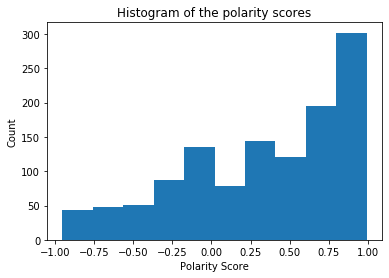

In [51]:
plt.hist(fee_sentiment.apply(lambda x: x['compound']))
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.title('Histogram of the polarity scores on fee')
plt.savefig('Reports/figures/fee_sentiment_v1.png')

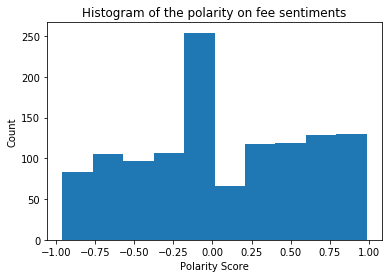

In [52]:
plt.hist(cleaned_fee_sentiment.apply(lambda x: x['compound']))
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.title('Histogram of the polarity on fee sentiments')
plt.savefig('Reports/figures/fee_sentiment_v2.png')

In [36]:
def return_term(text, term=None):
    if term in text:
        return text
    else:
        return 0

## Topic Extraction

In [228]:
# no_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=None, stop_words='english')
tf = tf_vectorizer.fit_transform(raw_data['Text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
lda = LatentDirichletAllocation(n_components=5,
                                max_iter=10, 
                                random_state=0).fit(tf)

In [ ]:
no_top_words = 20
display_topics(lda, tf_feature_names, no_top_words)

In [24]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## K-means

In [53]:
document = [T for T in raw_data['Text']]

In [54]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(document)

In [55]:
true_k = 5
clf = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
data = clf.fit(X)
centroids = clf.cluster_centers_

In [57]:
print("Top terms per cluster:")
order_centroids = clf.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
print("\n")

Top terms per cluster:
Cluster 0:
 fargo
 bank
 account
 fee
 custom
 charg
 million
 credit
 check
 loan
 open
 said
 servic
 rate
 card
 money
 pay
 mortgag
 payment
 year
Cluster 1:
 rate
 report
 fargo
 share
 price
 object
 th
 april
 upgrad
 reiter
 issu
 compani
 tuesday
 hold
 set
 stock
 isi
 spark
 strongbuy
 outperform
Cluster 2:
 loan
 auto
 car
 credit
 bad
 refin
 rate
 refinanc
 financ
 bank
 use
 chase
 best
 upsid
 need
 toyota
 subprim
 know
 work
 money
Cluster 3:
 bank
 need
 usaa
 chase
 citibank
 creditunion
 navyfeder
 wellsfargo
 usbank
 account
 bankofamerica
 money
 cash
 activ
 make
 trustworthi
 legal
 free
 capitalon
 hr
Cluster 4:
 fargo
 bank
 fee
 account
 wellsfargo
 rt
 year
 rate
 money
 like
 credit
 charg
 custom
 pay
 compani
 card
 loan
 mortgag
 time
 make


